# Задача 6. Компьютерное зрение: задача сегментации

* **Дедлайн**: 11.04.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

Обучаем Сегментацию:
- https://colab.research.google.com/drive/1eUIOnLFB_9_6CJ3dVZxY9TV_gCqDAmaV?authuser=1#scrollTo=SjKfL5X_RbzH --- тут мы обучали на большом датасете одну эпоху.
- https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view?usp=sharing --- тут лежит датасет который мы будем использовать.

Мы хотим обучить наш unet на небольшом датасете. Нужно заполнить репорт и сделать выводы.
Чтобы успеть сделать много экспериментов нужна видеокарта. Можно использовать colab, тут есть бесплатные gpu ресурсы --- так будет быстрее.


-  Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
-  Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
-  Попробовать улучшить качество изменяя архитектуру.
- [ ] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
-  * (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [1]:

import random
import os
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A



C:\Users\temer\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 79
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda")


Загрузка данных и разбиение на выборки


In [3]:
data_dir = "dataset"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

all_image_files = sorted([f for f in os.listdir(images_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
all_mask_files = sorted([f for f in os.listdir(masks_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Всего изображений: {len(all_image_files)}, Всего масок: {len(all_mask_files)}")

train_images, test_images, train_masks, test_masks = train_test_split(
    all_image_files, all_mask_files, test_size=0.2, random_state=SEED)

print(f"Обучающих изображений: {len(train_images)}, Тестовых изображений: {len(test_images)}")

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.15, random_state=SEED)

print(f"Итого: Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")


Всего изображений: 2000, Всего масок: 2000
Обучающих изображений: 1600, Тестовых изображений: 400
Итого: Train: 1360, Val: 240, Test: 400


Метрика качества сегментации: Jaccard Index (IoU)

In [4]:
def calculate_iou(pred_mask: torch.Tensor, true_mask: torch.Tensor) -> float:
    pred_bool = pred_mask.bool()
    true_bool = true_mask.bool()
    intersection = (pred_bool & true_bool).float().sum(dim=(-1, -2))
    union = (pred_bool | true_bool).float().sum(dim=(-1, -2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item() if iou.ndim > 0 else iou.item()

Проверка переобучения на одном батче

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=32):
        super(UNetModel, self).__init__()
        # энкодер
        self.enc1 = self._conv_block(in_channels, base_filters)
        self.enc2 = self._conv_block(base_filters, base_filters*2)
        self.enc3 = self._conv_block(base_filters*2, base_filters*4)
        self.enc4 = self._conv_block(base_filters*4, base_filters*8)
        # bottleneck
        self.bottleneck = self._conv_block(base_filters*8, base_filters*16)
        # декодер
        self.up4 = nn.ConvTranspose2d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.dec4 = self._conv_block(base_filters*16, base_filters*8)
        self.up3 = nn.ConvTranspose2d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(base_filters*8, base_filters*4)
        self.up2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(base_filters*4, base_filters*2)
        self.up1 = nn.ConvTranspose2d(base_filters*2, base_filters,   kernel_size=2, stride=2)
        self.dec1 = self._conv_block(base_filters*2, base_filters)
        # выход
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def _pad_to_match(self, x, target):
        """Паддим x, чтобы его spatial size совпал с target."""
        dy = target.size(2) - x.size(2)
        dx = target.size(3) - x.size(3)
        return F.pad(x, [dx//2, dx-dx//2, dy//2, dy-dy//2])

    def forward(self, x):
        # ----- энкодер -----
        x1 = self.enc1(x)
        x2 = self.enc2(F.max_pool2d(x1, 2))
        x3 = self.enc3(F.max_pool2d(x2, 2))
        x4 = self.enc4(F.max_pool2d(x3, 2))
        x5 = self.bottleneck(F.max_pool2d(x4, 2))

        # ----- декодер с паддингом -----
        u4 = self.up4(x5)
        u4 = self._pad_to_match(u4, x4)
        d4 = self.dec4(torch.cat([u4, x4], dim=1))

        u3 = self.up3(d4)
        u3 = self._pad_to_match(u3, x3)
        d3 = self.dec3(torch.cat([u3, x3], dim=1))

        u2 = self.up2(d3)
        u2 = self._pad_to_match(u2, x2)
        d2 = self.dec2(torch.cat([u2, x2], dim=1))

        u1 = self.up1(d2)
        u1 = self._pad_to_match(u1, x1)
        d1 = self.dec1(torch.cat([u1, x1], dim=1))

        return self.out_conv(d1)


Теперь настроим процедуру обучения на одном батче. Будем использовать функцию потерь BCEWithLogitsLoss

Оптимизатор возьмем Adam с небольшим начальным learning rate (например, 1e-3).

1. Выберем 4 изображения из обучающей выборки, загрузим их и соответствующие маски.

2. Будем повторно обучать модель на этих 4 примерах в течение нескольких эпох, пока ошибка не станет очень маленькой.
3. После обучения оценим IoU на этих 4 примерах (должен быть близок к 1) и на всей тестовой выборке (ожидаем низкое качество, т.к. модель видела только 4 изображения).

In [7]:
def load_image_mask(image_filename: str, mask_filename: str):
    img = Image.open(os.path.join(images_dir, image_filename)).convert("RGB")
    mask = Image.open(os.path.join(masks_dir, mask_filename)).convert("L")
    img_array = np.array(img) / 255.0
    mask_array = np.array(mask) / 255.0
    img_tensor = torch.FloatTensor(img_array).permute(2, 0, 1)  # [C, H, W]
    mask_tensor = torch.FloatTensor(mask_array).unsqueeze(0)  # [1, H, W]
    return img_tensor, mask_tensor


small_train_imgs = train_images[:4]
small_train_masks = train_masks[:4]

batch_images = []
batch_masks = []
for img_file, mask_file in zip(small_train_imgs, small_train_masks):
    img_t, mask_t = load_image_mask(img_file, mask_file)
    batch_images.append(img_t)
    batch_masks.append(mask_t)
batch_images = torch.stack(batch_images)
batch_masks = torch.stack(batch_masks)
print("Размер батча изображений:", batch_images.shape)
print("Размер батча масок:", batch_masks.shape)

model_overfit = UNetModel(in_channels=3, out_channels=1, base_filters=32).to(device)
batch_images = batch_images.to(device)
batch_masks = batch_masks.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=1e-3)


Размер батча изображений: torch.Size([4, 3, 800, 600])
Размер батча масок: torch.Size([4, 1, 800, 600])


In [9]:
num_epochs = 500
for epoch in range(1, num_epochs + 1):
    model_overfit.train()
    optimizer.zero_grad()
    outputs = model_overfit(batch_images)
    loss = criterion(outputs, batch_masks)
    loss.backward()
    optimizer.step()

    # Каждые 10 эпох печатаем текущий loss и IoU
    if epoch % 50 == 0:
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        iou_val = calculate_iou(preds.cpu(), batch_masks.cpu())
        print(f"Эпоха {epoch}: loss = {loss.item():.4f}, IoU = {iou_val:.4f}")
        if iou_val > 0.98:
            print("Достигнут очень высокий IoU на обучающем батче, останавливаем обучение.")
            break


Эпоха 50: loss = 0.5809, IoU = 0.6407
Эпоха 100: loss = 0.4945, IoU = 0.5036
Эпоха 150: loss = 0.1774, IoU = 0.8640
Эпоха 200: loss = 0.2903, IoU = 0.7854
Эпоха 250: loss = 0.2319, IoU = 0.8216
Эпоха 300: loss = 0.6988, IoU = 0.4550
Эпоха 350: loss = 0.5209, IoU = 0.5218
Эпоха 400: loss = 0.4503, IoU = 0.4646
Эпоха 450: loss = 0.6182, IoU = 0.6234
Эпоха 500: loss = 0.4596, IoU = 0.6713


In [10]:
model_overfit.eval()
with torch.no_grad():
    outputs = model_overfit(batch_images)
    preds = (torch.sigmoid(outputs) >= 0.5).float()
    train_iou = calculate_iou(preds.cpu(), batch_masks.cpu())
    print(f"IoU на 4 обучающих изображениях: {train_iou:.4f}")

    test_ious = []
    for img_file, mask_file in zip(test_images, test_masks):
        img_t, mask_t = load_image_mask(img_file, mask_file)
        img_t = img_t.unsqueeze(0).to(device)
        mask_t = mask_t.unsqueeze(0).to(device)
        out = model_overfit(img_t)
        pred_mask = (torch.sigmoid(out) >= 0.5).float()
        iou_val = calculate_iou(pred_mask.cpu(), mask_t.cpu())
        test_ious.append(iou_val)
    mean_test_iou = sum(test_ious) / len(test_ious) if len(test_ious) > 0 else 0
    print(f"Средний IoU на тестовой выборке: {mean_test_iou:.4f}")


IoU на 4 обучающих изображениях: 0.6864
Средний IoU на тестовой выборке: 0.4284


## Полноценное обучение модели на всем датасете


In [17]:
import cv2  # в начале файла

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir, transform=None, resize_to=(512, 512)):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.resize_to = resize_to  # (width, height)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        # Загружаем изображение и маску
        img = Image.open(os.path.join(self.images_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, mask_name)).convert("L")

        # В numpy
        img = np.array(img)
        mask = np.array(mask)

        # Resize изображений и масок
        img = cv2.resize(img, self.resize_to, interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, self.resize_to, interpolation=cv2.INTER_NEAREST)

        # Аугментации (если заданы)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Нормализация и в тензоры
        img_tensor = torch.FloatTensor(img / 255.0).permute(2, 0, 1)   # [C, H, W]
        mask_tensor = torch.FloatTensor(mask / 255.0).unsqueeze(0)     # [1, H, W]
        return img_tensor, mask_tensor



train_dataset = SegmentationDataset(train_images, train_masks, images_dir, masks_dir, transform=None)
val_dataset = SegmentationDataset(val_images, val_masks, images_dir, masks_dir, transform=None)
test_dataset = SegmentationDataset(test_images, test_masks, images_dir, masks_dir, transform=None)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [18]:
import gc

# Устанавливаем более безопасный размер батча
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

torch.cuda.empty_cache()
gc.collect()
# Инициализация модели, оптимизатора и функции потерь
model = UNetModel(in_channels=3, out_channels=1, base_filters=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

for epoch in range(1, num_epochs + 1):
    torch.cuda.empty_cache()  # очищаем кэш CUDA в начале каждой эпохи

    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_iou = calculate_iou(preds.cpu(), masks.cpu())
        total_iou += batch_iou

    train_loss = total_loss / len(train_loader)
    train_iou = total_iou / len(train_loader)

    # Валидация
    model.eval()
    val_loss_total = 0.0
    val_iou_total = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            val_loss_total += criterion(outputs, masks).item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_iou_total += calculate_iou(preds.cpu(), masks.cpu())

    val_loss = val_loss_total / len(val_loader) if len(val_loader) > 0 else 0.0
    val_iou = val_iou_total / len(val_loader) if len(val_loader) > 0 else 0.0

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)

    print(f"Эпоха {epoch}/{num_epochs} - Loss: {train_loss:.4f} (val {val_loss:.4f}), "
          f"IoU: {train_iou:.4f} (val {val_iou:.4f})")


Эпоха 1/20 - Loss: 0.6395 (val 0.5909), IoU: 0.4984 (val 0.5289)
Эпоха 2/20 - Loss: 0.6108 (val 0.6470), IoU: 0.5451 (val 0.3821)
Эпоха 3/20 - Loss: 0.6092 (val 0.6195), IoU: 0.5491 (val 0.4718)
Эпоха 4/20 - Loss: 0.5893 (val 0.5824), IoU: 0.5642 (val 0.5787)
Эпоха 5/20 - Loss: 0.5796 (val 0.5822), IoU: 0.5736 (val 0.5661)
Эпоха 6/20 - Loss: 0.5749 (val 0.5763), IoU: 0.5743 (val 0.5777)
Эпоха 7/20 - Loss: 0.5781 (val 0.5738), IoU: 0.5638 (val 0.5887)
Эпоха 8/20 - Loss: 0.5708 (val 0.5705), IoU: 0.5705 (val 0.5978)
Эпоха 9/20 - Loss: 0.5646 (val 0.5750), IoU: 0.5727 (val 0.5760)
Эпоха 10/20 - Loss: 0.5639 (val 0.5835), IoU: 0.5754 (val 0.4028)
Эпоха 11/20 - Loss: 0.5045 (val 0.5383), IoU: 0.6247 (val 0.6357)
Эпоха 12/20 - Loss: 0.4908 (val 0.5016), IoU: 0.6305 (val 0.6385)
Эпоха 13/20 - Loss: 0.4902 (val 0.5007), IoU: 0.6295 (val 0.6310)
Эпоха 14/20 - Loss: 0.4917 (val 0.5028), IoU: 0.6281 (val 0.6120)
Эпоха 15/20 - Loss: 0.4538 (val 0.4781), IoU: 0.6557 (val 0.6817)
Эпоха 16/20 - Loss:

По завершении обучения определим, на какой эпохе был достигнут наилучший результат по IoU на валидации, и выведем этот результат. Затем оценим качество работы модели на тестовой выборке, посчитав средний IoU по всем тестовым изображениям.

In [19]:
best_epoch = np.argmax(history['val_iou']) + 1
best_val_iou = history['val_iou'][best_epoch - 1]
print(f"Лучший результат на валидации: эпоха {best_epoch} с IoU = {best_val_iou:.4f}")

model.eval()
ious = []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        ious.append(calculate_iou(preds.cpu(), masks.cpu()))
mean_iou = np.mean(ious) if ious else 0.0
print(f"Средний IoU на тестовой выборке: {mean_iou:.4f}")


Лучший результат на валидации: эпоха 20 с IoU = 0.7249
Средний IoU на тестовой выборке: 0.7232


## Графики обучения


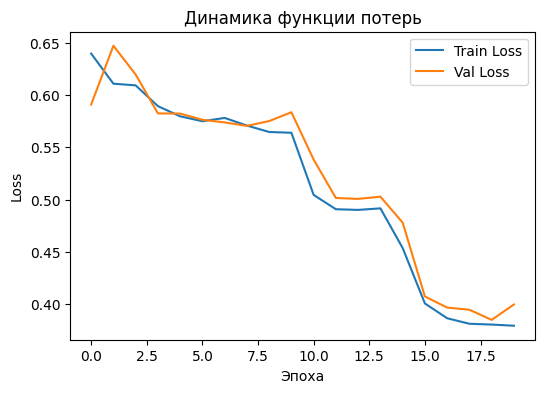

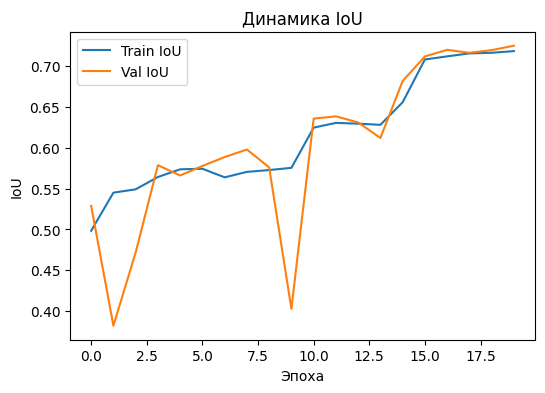

In [20]:
# График функции потерь (train vs val) по эпохам
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика функции потерь')
plt.legend()
plt.show()

# График IoU (train vs val) по эпохам
plt.figure(figsize=(6, 4))
plt.plot(history['train_iou'], label='Train IoU')
plt.plot(history['val_iou'], label='Val IoU')
plt.xlabel('Эпоха')
plt.ylabel('IoU')
plt.title('Динамика IoU')
plt.legend()
plt.show()


## Визуализация худших предсказаний

Худшие IoU на тесте: [0.35099646 0.38282883 0.39973119 0.41210285 0.43638569]


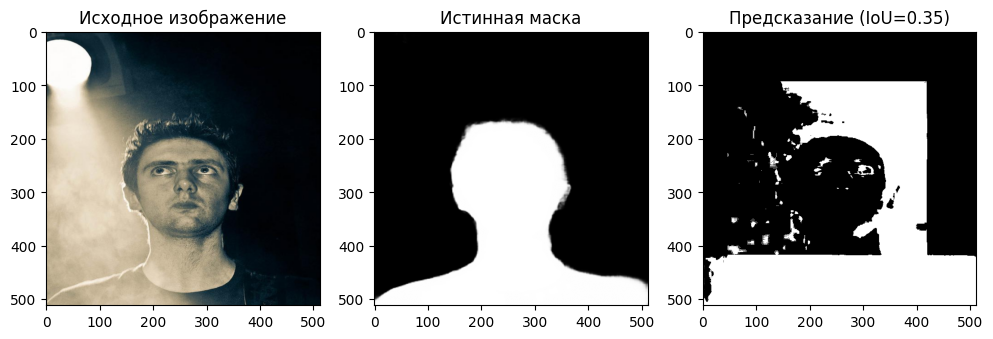

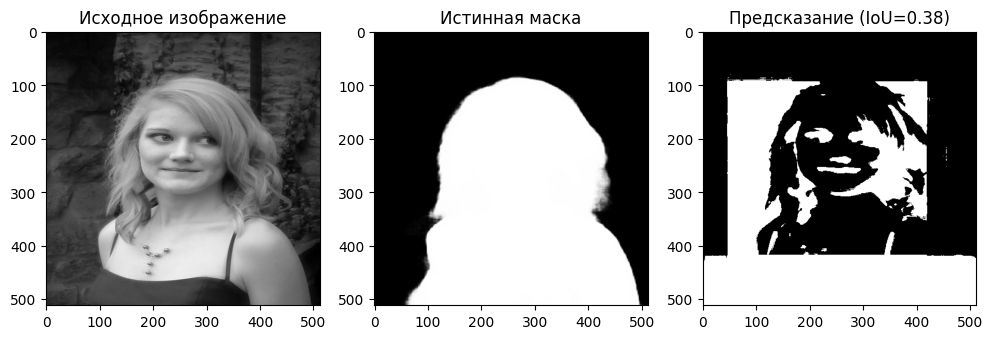

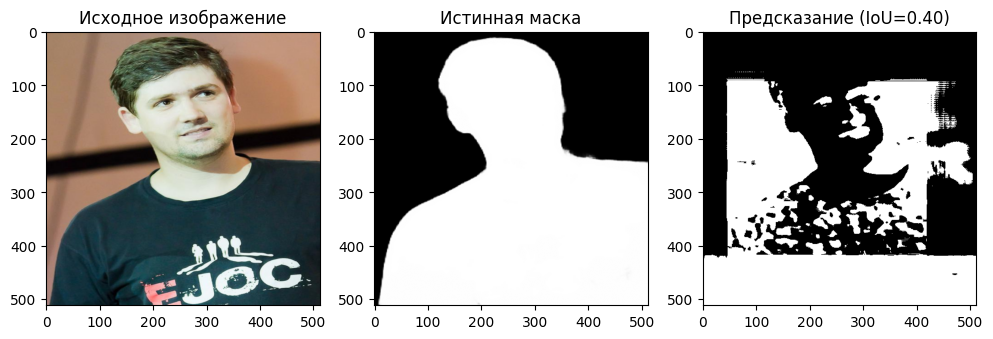

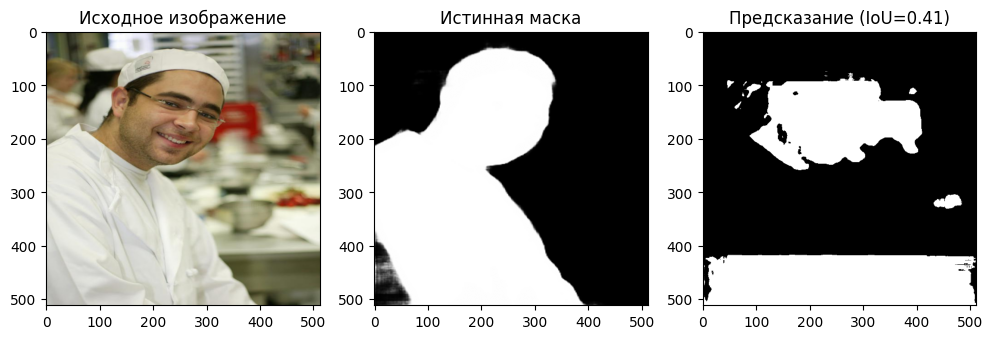

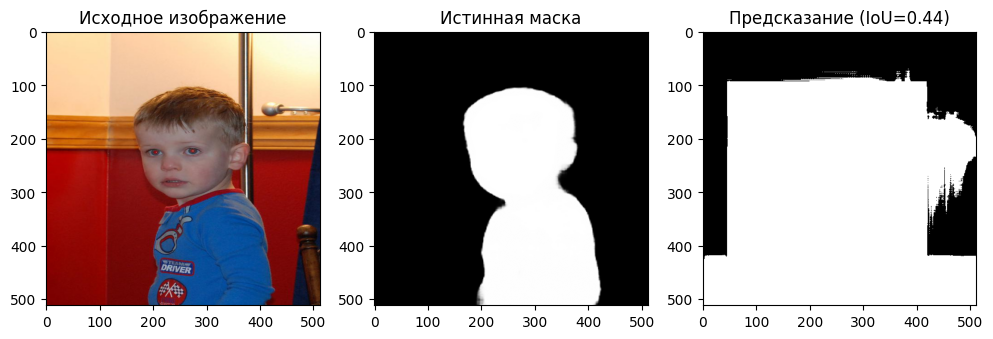

In [21]:
ious = np.array(ious)
worst_indices = np.argsort(ious)[:5]
print("Худшие IoU на тесте:", ious[worst_indices])

# Визуализируем 5 худших случаев
for idx in worst_indices:
    img_tensor, true_mask = test_dataset[idx]
    img_input = img_tensor.unsqueeze(0).to(device)  # [1, 3, H, W]
    model.eval()
    with torch.no_grad():
        pred_logits = model(img_input)
        pred_mask = (torch.sigmoid(pred_logits) >= 0.5).cpu().numpy().squeeze()
    img_np = img_tensor.numpy().transpose(1, 2, 0)  # [H, W, 3]
    true_mask_np = true_mask.numpy().squeeze()  # [H, W]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Исходное изображение")
    axs[1].imshow(true_mask_np, cmap='gray')
    axs[1].set_title("Истинная маска")
    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title(f"Предсказание (IoU={ious[idx]:.2f})")
    plt.show()


## Улучшение качества без изменения архитектуры

In [22]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.9, 1.1), translate_percent=(-0.1, 0.1), rotate=(-15, 15), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
], additional_targets={'mask': 'mask'})

train_dataset_aug = SegmentationDataset(train_images, train_masks, images_dir, masks_dir, transform=train_transform)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=4, shuffle=True, drop_last=True)


Теперь реализуем комбинированную функцию потерь BCE + DiceLoss

In [23]:
def dice_loss(pred_logits: torch.Tensor, true_mask: torch.Tensor) -> torch.Tensor:
    prob = torch.sigmoid(pred_logits)
    prob = prob.view(-1)
    true_flat = true_mask.view(-1)
    intersection = (prob * true_flat).sum()
    eps = 1e-5
    dice_coeff = (2 * intersection + eps) / (prob.sum() + true_flat.sum() + eps)
    return 1 - dice_coeff


class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred_logits: torch.Tensor, true_mask: torch.Tensor):
        bce_loss = self.bce(pred_logits, true_mask)
        d_loss = dice_loss(pred_logits, true_mask)
        return bce_loss + d_loss


combined_loss_fn = DiceBCELoss()


In [25]:
model = UNetModel(in_channels=3, out_channels=1, base_filters=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

num_epochs = 30
best_val_iou = 0.0
best_model_wts = None

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    for imgs, masks in train_loader_aug:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = combined_loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        epoch_iou += calculate_iou(preds.cpu(), masks.cpu())
    epoch_loss /= len(train_loader_aug)
    epoch_iou /= len(train_loader_aug)

    model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_iou += calculate_iou(preds.cpu(), masks.cpu())
    val_iou = val_iou / len(val_loader) if len(val_loader) > 0 else 0.0

    print(f"Эпоха {epoch}: Train loss={epoch_loss:.3f}, Train IoU={epoch_iou:.3f}, Val IoU={val_iou:.3f}")
    scheduler.step(val_iou)
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        best_model_wts = model.state_dict().copy()

print(f"Лучший IoU на валидации после улучшений: {best_val_iou:.4f}")
if best_model_wts:
    model.load_state_dict(best_model_wts)

Эпоха 1: Train loss=1.079, Train IoU=0.521, Val IoU=0.576
Эпоха 2: Train loss=1.001, Train IoU=0.558, Val IoU=0.586
Эпоха 3: Train loss=0.980, Train IoU=0.563, Val IoU=0.583
Эпоха 4: Train loss=0.967, Train IoU=0.574, Val IoU=0.559
Эпоха 5: Train loss=0.969, Train IoU=0.569, Val IoU=0.596
Эпоха 6: Train loss=0.960, Train IoU=0.570, Val IoU=0.599
Эпоха 7: Train loss=0.956, Train IoU=0.573, Val IoU=0.601
Эпоха 8: Train loss=0.959, Train IoU=0.572, Val IoU=0.600
Эпоха 9: Train loss=0.967, Train IoU=0.572, Val IoU=0.595
Эпоха 10: Train loss=0.949, Train IoU=0.568, Val IoU=0.535
Эпоха 11: Train loss=0.954, Train IoU=0.570, Val IoU=0.596
Эпоха 12: Train loss=0.931, Train IoU=0.581, Val IoU=0.597
Эпоха 13: Train loss=0.926, Train IoU=0.581, Val IoU=0.600
Эпоха 14: Train loss=0.921, Train IoU=0.585, Val IoU=0.604
Эпоха 15: Train loss=0.921, Train IoU=0.587, Val IoU=0.574
Эпоха 16: Train loss=0.916, Train IoU=0.584, Val IoU=0.605
Эпоха 17: Train loss=0.913, Train IoU=0.596, Val IoU=0.603
Эпоха 

In [26]:
model.eval()
ious_new = []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        ious_new.append(calculate_iou(preds.cpu(), masks.cpu()))
mean_iou_new = np.mean(ious_new) if ious_new else 0.0
print(f"Средний IoU на тесте после улучшений: {mean_iou_new:.4f}")


Средний IoU на тесте после улучшений: 0.6562


## Test-time аугментация (TTA) для улучшения предсказаний

In [27]:
# Расчет IoU без TTA и с TTA на тестовом наборе
ious_no_tta = []
ious_tta = []
model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        # Предсказание без TTA
        out = model(imgs)
        preds_no_tta = (torch.sigmoid(out) >= 0.5).float()
        ious_no_tta.append(calculate_iou(preds_no_tta.cpu(), masks.cpu()))
        # Предсказание с горизонтальным flip TTA
        imgs_flipped = torch.flip(imgs, dims=[3])
        out_flipped = model(imgs_flipped)
        prob_flipped = torch.sigmoid(out_flipped)
        prob_unflipped = torch.flip(prob_flipped, dims=[3])
        prob_avg = (torch.sigmoid(out) + prob_unflipped) / 2.0
        preds_tta = (prob_avg >= 0.5).float()
        ious_tta.append(calculate_iou(preds_tta.cpu(), masks.cpu()))

mean_iou_no_tta = np.mean(ious_no_tta) if ious_no_tta else 0.0
mean_iou_tta = np.mean(ious_tta) if ious_tta else 0.0
print(f"Средний IoU без TTA: {mean_iou_no_tta:.4f}")
print(f"Средний IoU с TTA (гориз. флип): {mean_iou_tta:.4f}")


Средний IoU без TTA: 0.6562
Средний IoU с TTA (гориз. флип): 0.6588


## Улучшение качества с изменением архитектуры

In [30]:
class LargeUNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1, base_filters: int = 64):
        super(LargeUNet, self).__init__()

        def conv_block_bn(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block_bn(in_channels, base_filters)
        self.enc2 = conv_block_bn(base_filters, base_filters * 2)
        self.enc3 = conv_block_bn(base_filters * 2, base_filters * 4)
        self.enc4 = conv_block_bn(base_filters * 4, base_filters * 8)
        self.bottom = conv_block_bn(base_filters * 8, base_filters * 16)
        # Декодер
        self.up4 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = conv_block_bn(base_filters * 16, base_filters * 8)
        self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = conv_block_bn(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = conv_block_bn(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = conv_block_bn(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(nn.functional.max_pool2d(x1, 2))
        x3 = self.enc3(nn.functional.max_pool2d(x2, 2))
        x4 = self.enc4(nn.functional.max_pool2d(x3, 2))
        x5 = self.bottom(nn.functional.max_pool2d(x4, 2))
        x_up4 = torch.cat([self.up4(x5), x4], dim=1)
        x_dec4 = self.dec4(x_up4)
        x_up3 = torch.cat([self.up3(x_dec4), x3], dim=1)
        x_dec3 = self.dec3(x_up3)
        x_up2 = torch.cat([self.up2(x_dec3), x2], dim=1)
        x_dec2 = self.dec2(x_up2)
        x_up1 = torch.cat([self.up1(x_dec2), x1], dim=1)
        x_dec1 = self.dec1(x_up1)
        output = self.out_conv(x_dec1)
        return output


large_model = LargeUNet(in_channels=3, out_channels=1, base_filters=16).to(device)
param_count = sum(p.numel() for p in large_model.parameters())
print("Параметров в увеличенной модели U-Net:", param_count)
large_model.to(device)


Параметров в увеличенной модели U-Net: 1944049


LargeUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [32]:
optimizer = optim.Adam(large_model.parameters(), lr=1e-3)
best_val_iou_big = 0.0

for epoch in range(1, 20):
    large_model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    for imgs, masks in train_loader_aug:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = large_model(imgs)
        loss = combined_loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        epoch_iou += calculate_iou(preds.cpu(), masks.cpu())

    epoch_loss /= len(train_loader_aug)
    epoch_iou /= len(train_loader_aug)

    # Быстрая оценка на валидации
    large_model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = (torch.sigmoid(large_model(imgs)) >= 0.5).float()
            val_iou += calculate_iou(preds.cpu(), masks.cpu())

    val_iou /= len(val_loader) if len(val_loader) > 0 else 1
    if val_iou > best_val_iou_big:
        best_val_iou_big = val_iou

    print(f"Эпоха {epoch}: Train loss={epoch_loss:.4f}, Train IoU={epoch_iou:.4f}, Val IoU={val_iou:.4f}")

print(f"Лучший val IoU для увеличенной модели: {best_val_iou_big:.4f}")


Эпоха 1: Train loss=0.9094, Train IoU=0.5854, Val IoU=0.6245
Эпоха 2: Train loss=0.8615, Train IoU=0.6099, Val IoU=0.6228
Эпоха 3: Train loss=0.8001, Train IoU=0.6436, Val IoU=0.6442
Эпоха 4: Train loss=0.7395, Train IoU=0.6706, Val IoU=0.6747
Эпоха 5: Train loss=0.6900, Train IoU=0.6901, Val IoU=0.7049
Эпоха 6: Train loss=0.6640, Train IoU=0.7052, Val IoU=0.7404
Эпоха 7: Train loss=0.6174, Train IoU=0.7253, Val IoU=0.7100
Эпоха 8: Train loss=0.6045, Train IoU=0.7299, Val IoU=0.6815
Эпоха 9: Train loss=0.5783, Train IoU=0.7415, Val IoU=0.7549
Эпоха 10: Train loss=0.5709, Train IoU=0.7432, Val IoU=0.7570
Эпоха 11: Train loss=0.5488, Train IoU=0.7523, Val IoU=0.7161
Эпоха 12: Train loss=0.5214, Train IoU=0.7656, Val IoU=0.7756
Эпоха 13: Train loss=0.5034, Train IoU=0.7748, Val IoU=0.7780
Эпоха 14: Train loss=0.5009, Train IoU=0.7741, Val IoU=0.8007
Эпоха 15: Train loss=0.4791, Train IoU=0.7825, Val IoU=0.7916
Эпоха 16: Train loss=0.4631, Train IoU=0.7918, Val IoU=0.8130
Эпоха 17: Train l

In [33]:
large_model.eval()
ious_big = []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = large_model(imgs)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        ious_big.append(calculate_iou(preds.cpu(), masks.cpu()))
mean_iou_big = np.mean(ious_big) if ious_big else 0.0
print(f"Средний IoU на тесте (увеличенная модель): {mean_iou_big:.4f}")


Средний IoU на тесте (увеличенная модель): 0.8039


## 5-фолд кросс-валидация на обучающей выборке

In [34]:
from sklearn.model_selection import KFold

# Объединяем исходные train+val списки для кросс-валидации
trainval_images = train_images + val_images
trainval_masks = train_masks + val_masks

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
fold_histories = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(trainval_images), 1):
    print(f"Фолд {fold}: обучение на {len(train_idx)} изображениях, валидация на {len(val_idx)} изображениях")
    fold_train_imgs = [trainval_images[i] for i in train_idx]
    fold_train_masks = [trainval_masks[i] for i in train_idx]
    fold_val_imgs = [trainval_images[i] for i in val_idx]
    fold_val_masks = [trainval_masks[i] for i in val_idx]
    # Датасеты для фолда
    dataset_train = SegmentationDataset(fold_train_imgs, fold_train_masks, images_dir, masks_dir,
                                        transform=train_transform)
    dataset_val = SegmentationDataset(fold_val_imgs, fold_val_masks, images_dir, masks_dir, transform=None)
    loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, drop_last=True)
    loader_val = DataLoader(dataset_val, batch_size=4, shuffle=False)
    model_cv = UNetModel(in_channels=3, out_channels=1, base_filters=32).to(device)
    optimizer_cv = optim.Adam(model_cv.parameters(), lr=1e-3)
    history_cv = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}
    best_val_iou = 0.0
    best_wts = None
    num_epochs_cv = 15
    for epoch in range(1, num_epochs_cv + 1):
        model_cv.train()
        train_loss = 0.0
        train_iou = 0.0
        for imgs, masks in loader_train:
            imgs = imgs.to(device)
            masks = masks.to(device)
            optimizer_cv.zero_grad()
            outputs = model_cv(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer_cv.step()
            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            train_iou += calculate_iou(preds.cpu(), masks.cpu())
        train_loss /= len(loader_train)
        train_iou /= len(loader_train)
        model_cv.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for imgs, masks in loader_val:
                imgs = imgs.to(device)
                masks = masks.to(device)
                outputs = model_cv(imgs)
                val_loss += criterion(outputs, masks).item()
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                val_iou += calculate_iou(preds.cpu(), masks.cpu())
        val_loss /= len(loader_val) if len(loader_val) > 0 else 1.0
        val_iou /= len(loader_val) if len(loader_val) > 0 else 1.0
        history_cv['train_loss'].append(train_loss)
        history_cv['val_loss'].append(val_loss)
        history_cv['train_iou'].append(train_iou)
        history_cv['val_iou'].append(val_iou)
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            best_wts = model_cv.state_dict().copy()
        print(f" Фолд {fold} Эпоха {epoch}: train IoU={train_iou:.3f}, val IoU={val_iou:.3f}")
    fold_histories.append(history_cv)
    if best_wts:
        model_cv.load_state_dict(best_wts)
    fold_models.append(model_cv)


Фолд 1: обучение на 1280 изображениях, валидация на 320 изображениях
 Фолд 1 Эпоха 1: train IoU=0.431, val IoU=0.580
 Фолд 1 Эпоха 2: train IoU=0.485, val IoU=0.565
 Фолд 1 Эпоха 3: train IoU=0.526, val IoU=0.508
 Фолд 1 Эпоха 4: train IoU=0.534, val IoU=0.585
 Фолд 1 Эпоха 5: train IoU=0.534, val IoU=0.523
 Фолд 1 Эпоха 6: train IoU=0.547, val IoU=0.526
 Фолд 1 Эпоха 7: train IoU=0.539, val IoU=0.593
 Фолд 1 Эпоха 8: train IoU=0.544, val IoU=0.534
 Фолд 1 Эпоха 9: train IoU=0.545, val IoU=0.582
 Фолд 1 Эпоха 10: train IoU=0.548, val IoU=0.592
 Фолд 1 Эпоха 11: train IoU=0.545, val IoU=0.524
 Фолд 1 Эпоха 12: train IoU=0.551, val IoU=0.551
 Фолд 1 Эпоха 13: train IoU=0.554, val IoU=0.568
 Фолд 1 Эпоха 14: train IoU=0.548, val IoU=0.585
 Фолд 1 Эпоха 15: train IoU=0.557, val IoU=0.553
Фолд 2: обучение на 1280 изображениях, валидация на 320 изображениях
 Фолд 2 Эпоха 1: train IoU=0.374, val IoU=0.164
 Фолд 2 Эпоха 2: train IoU=0.504, val IoU=0.590
 Фолд 2 Эпоха 3: train IoU=0.518, val Io

## Ансамбль моделей vs одиночная модель

In [35]:
ensemble_ious = []
single_model_ious = []

single_model = fold_models[0]
single_model.eval()

for imgs, masks in test_loader:
    imgs = imgs.to(device)
    masks = masks.to(device)
    probs = []
    for model_cv in fold_models:
        model_cv.eval()
        with torch.no_grad():
            out = model_cv(imgs)
            prob = torch.sigmoid(out)
        probs.append(prob)
    # Усредняем вероятности
    mean_prob = sum(probs) / len(probs)
    pred_mask_ens = (mean_prob >= 0.5).float()
    iou_ens = calculate_iou(pred_mask_ens.cpu(), masks.cpu())
    ensemble_ious.append(iou_ens)
    # Предсказание одной модели
    with torch.no_grad():
        out_single = single_model(imgs)
        pred_mask_single = (torch.sigmoid(out_single) >= 0.5).float()
    iou_single = calculate_iou(pred_mask_single.cpu(), masks.cpu())
    single_model_ious.append(iou_single)

mean_iou_ens = np.mean(ensemble_ious) if ensemble_ious else 0.0
mean_iou_single = np.mean(single_model_ious) if single_model_ious else 0.0
print(f"Средний IoU ансамбля (5 моделей): {mean_iou_ens:.4f}")
print(f"Средний IoU одной модели: {mean_iou_single:.4f}")


Средний IoU ансамбля (5 моделей): 0.5661
Средний IoU одной модели: 0.5439


Анализ ошибок на тесте по фолдам

In [36]:
worst_per_model = []
for model_cv in fold_models:
    ious_cv = []
    model_cv.eval()
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            out = model_cv(imgs)
            pred_mask = (torch.sigmoid(out) >= 0.5).float()
            iou_val = calculate_iou(pred_mask.cpu(), masks.cpu())
            ious_cv.append(iou_val)
    ious_cv = np.array(ious_cv)
    worst_idxs = np.argsort(ious_cv)[:3]  # индексы 3 худших для данной модели
    worst_per_model.append(set(worst_idxs))
    print("Худшие индексы для модели:", worst_idxs)
common_worst = set.intersection(*worst_per_model) if worst_per_model else set()
print("Общие сложные примеры для всех моделей:", common_worst)


Худшие индексы для модели: [186 127 119]
Худшие индексы для модели: [186 102 127]
Худшие индексы для модели: [186 127 119]
Худшие индексы для модели: [127 186 193]
Худшие индексы для модели: [165 127 257]
Общие сложные примеры для всех моделей: {np.int64(127)}


## Использование предобученного энкодера

In [37]:
from segmentation_models_pytorch import Unet

pretrained_model = Unet(
    encoder_name="resnet34",  # энкодер ResNet-34
    encoder_weights="imagenet",  # предобученные веса на ImageNet
    in_channels=3,  # три канала на вход (RGB)
    classes=1  # один выходной канал (бинарная сегментация)
).to(device)
print("Количество параметров предобученного U-Net:", sum(p.numel() for p in pretrained_model.parameters()))


C:\Users\temer\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\temer\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Количество параметров предобученного U-Net: 24436369


In [38]:
encoder_params = list(pretrained_model.encoder.parameters())
decoder_params = list(pretrained_model.decoder.parameters()) + list(pretrained_model.segmentation_head.parameters())
optimizer_pretrained = optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},
    {'params': decoder_params, 'lr': 1e-3}
])
criterion_pretrained = DiceBCELoss()

best_val_iou_pre = 0.0
best_wts_pre = None
for epoch in range(1, 20):
    pretrained_model.train()
    for imgs, masks in train_loader_aug:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer_pretrained.zero_grad()
        outputs = pretrained_model(imgs)
        loss = criterion_pretrained(outputs, masks)
        loss.backward()
        optimizer_pretrained.step()
    pretrained_model.eval()
    val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = (torch.sigmoid(pretrained_model(imgs)) >= 0.5).float()
            val_iou += calculate_iou(preds.cpu(), masks.cpu())
    val_iou = val_iou / len(val_loader) if len(val_loader) > 0 else 0.0
    if val_iou > best_val_iou_pre:
        best_val_iou_pre = val_iou
        best_wts_pre = pretrained_model.state_dict().copy()
    print(f"Эпоха {epoch}: val IoU = {val_iou:.4f}")
if best_wts_pre:
    pretrained_model.load_state_dict(best_wts_pre)
print(f"Лучший валидационный IoU с предобученным энкодером: {best_val_iou_pre:.4f}")


Эпоха 1: val IoU = 0.9601
Эпоха 2: val IoU = 0.9470
Эпоха 3: val IoU = 0.9615
Эпоха 4: val IoU = 0.9626
Эпоха 5: val IoU = 0.9609
Эпоха 6: val IoU = 0.9639
Эпоха 7: val IoU = 0.9573
Эпоха 8: val IoU = 0.9612
Эпоха 9: val IoU = 0.9661
Эпоха 10: val IoU = 0.9669
Эпоха 11: val IoU = 0.9612
Эпоха 12: val IoU = 0.9633
Эпоха 13: val IoU = 0.9614
Эпоха 14: val IoU = 0.9655
Эпоха 15: val IoU = 0.9647
Эпоха 16: val IoU = 0.9663
Эпоха 17: val IoU = 0.9572
Эпоха 18: val IoU = 0.9665
Эпоха 19: val IoU = 0.9609
Лучший валидационный IoU с предобученным энкодером: 0.9669


In [39]:
pretrained_model.eval()
ious_pre = []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = pretrained_model(imgs)
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        ious_pre.append(calculate_iou(preds.cpu(), masks.cpu()))
mean_iou_pre = np.mean(ious_pre) if ious_pre else 0.0
print(f"Средний IoU на тесте (предобученный энкодер): {mean_iou_pre:.4f}")


Средний IoU на тесте (предобученный энкодер): 0.9610
